In [258]:
import geopandas as gpd
import heapq
import numpy as np
import matplotlib.pyplot as plt

In [260]:
def doPlot():
    crimedataLocation = 'D:/AI/Project1/Shape/crime_dt.shp' 
    gridsize = 0.002
    crimedata = gpd.read_file(crimedataLocation)
    #print(crimedata)
    
    #crimedata.plot()
    bounds=np.array([[-73.59,45.49],[-73.55,45.49],[-73.55,45.53],[-73.59,45.53]])
    long,lat = bounds.T
    gridx = np.arange(min(long),max(long),gridsize)
    gridy = np.arange(min(lat),max(lat),gridsize)
    #print(gridx)
    #print(gridy)
    H, xedges, yedges = np.histogram2d(crimedata['geometry'].x, crimedata['geometry'].y,bins=[gridx, gridy])
    #print(H)
    plt.figure()
    #plt.plot(x,y,'ro')
    #plt.grid(True)
    #plt.figure()
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(H.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto')
    #plt.plot(x,y,'ro')
    #plt.colorbar()
    #plt.scatter(x,y,100,'r')
    plt.show()
    return H,xedges,yedges,gridsize


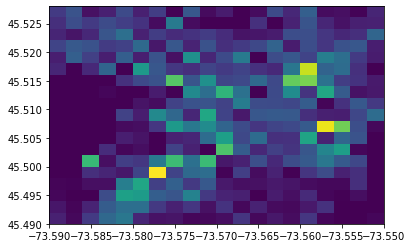

Mean is  48.665789473684214
Standard Deviation is  49.831784278477635
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 0

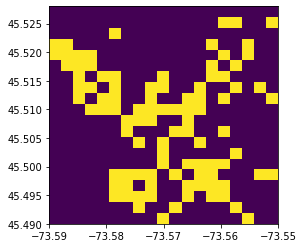

In [296]:
if __name__=="__main__":
    H,xedges,yedges,grid_size = doPlot()
    threshold_limit = thresholdCalc(H)
    #print(threshold_limit)
    reversesorted_array = H;
    
    reversesorted_array[reversesorted_array < threshold_limit] = 0
    reversesorted_array[reversesorted_array >= threshold_limit] = 1
    print(H)
    print(reversesorted_array)
    plt.imshow(reversesorted_array,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    source = np.array([-73.55,45.49])
    destination = np.array([-73.59,45.53])
    #print(H[-73.55,45.49])
    valid = findChild(source,destination,grid_size)
    #print(source[1])
    

In [238]:
def thresholdCalc(H):
    threshold = int(75)
    #reversesorted_array = -np.sort(-H)
    sorted_array = H.reshape(1,-1)
    sorted_array.sort()
    
    #reverse_sort = np.fliplr(H)
    #reverse_sort = sorted_array[::-1]
    numberOfElements = np.size(H,1)
    #calchighrisk = np.divide(threshold,100)
    #print(sorted_array[0])
    highriskNum = sorted_array[0][int(threshold/100 * sorted_array.shape[1])]
    #print(highriskNum)
    mean = np.mean(H)
    print("Mean is ",mean)
    sd = np.std(H)
    print("Standard Deviation is ",sd)
    return int(highriskNum)
    
    


In [ ]:
def hueristic

In [251]:
def findChild(source,destination,grid_size):
    #print(grid_size)
    #print(source[0])
    #print(source[1])
    valid = []
    for nextPosition in [(0,grid_size),(0,-grid_size),(grid_size,0),(-grid_size,0),(-grid_size,grid_size),(grid_size,-grid_size),(grid_size,grid_size),(-grid_size,-grid_size)]:
        nodePosition = (float(source[0]) + float(nextPosition[0]), float(source[1]) + float(nextPosition[1]))
        #to check valid points
        if nodePosition[0] <= source [0] and nodePosition[0] >= destination[0] and nodePosition[1] >= source[1] and nodePosition[1] <= destination[1]:
            valid.append(nodePosition)
        print("nodePosition",nodePosition)
        print("Valid Points",valid)
    return valid
    

{(19, 18): 0}
{(19, 18): 26.1725046566048}
[(26.1725046566048, (19, 18))]
None
(19, 18)
0
0
0
0
0
0
0
0
(19, 18)
0
0
0
0
0
0
0
0
(18, 17)
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
(17, 16)
2.8284271247461903
2.8284271247461903
2.8284271247461903
2.8284271247461903
2.8284271247461903
2.8284271247461903
2.8284271247461903
2.8284271247461903
(16, 15)
4.242640687119286
4.242640687119286
4.242640687119286
4.242640687119286
4.242640687119286
4.242640687119286
4.242640687119286
4.242640687119286
(15, 14)
5.656854249492381
5.656854249492381
5.656854249492381
5.656854249492381
5.656854249492381
5.656854249492381
5.656854249492381
5.656854249492381
(15, 15)
5.242640687119286
5.242640687119286
5.242640687119286
5.242640687119286
5.242640687119286
5.242640687119286
5.242640687119286
5.242640687119286
(17, 17)
2.414213562373095
2.414213562373095
2.414213562373095
2.414213562373095
2.4142135

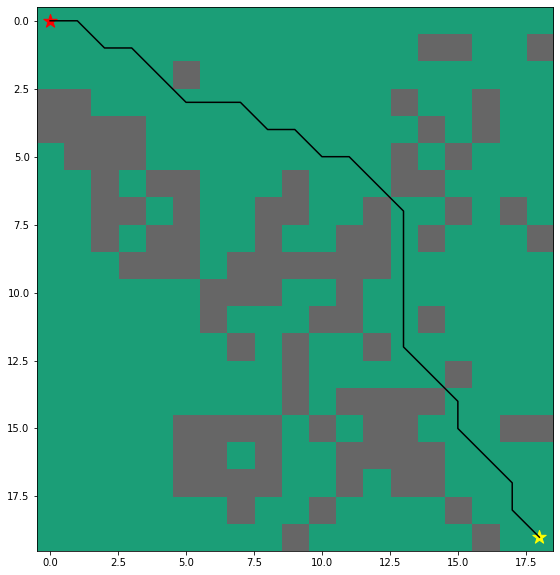

In [292]:
grid = reversesorted_array
# start point and goal
start = (19,18)
#print(start)
goal = (0,0)
#print(goal[0])

def heuristic(a, b):
    return np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]

    close_set = set()
    came_from = {}
    gscore = {start:0}
    print(gscore)
    fscore = {start:heuristic(start, goal)}
    print(fscore)
    oheap = []
    heapq.heappush(oheap, (fscore[start], start))
    print(oheap)
    print(heapq.heappush(oheap, (fscore[start], start)))
    #print(heapin)
    
    while oheap:

        current = heapq.heappop(oheap)[1]
        print(current)

        if current == goal:
            data = []
            print(came_from)
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            print(gscore[current])
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))
                
    return False

route = astar(grid, start, goal)
print(route)
route = route + [start]
route = route[::-1]
print(route)

x_coords = []
y_coords = []

for i in (range(0,len(route))):
    x = route[i][0]
    y = route[i][1]
    x_coords.append(x)
    y_coords.append(y)

# plot map and path
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "*", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "*", color = "red", s = 200)
ax.plot(y_coords,x_coords, color = "black")
plt.show()

#reversesorted_array